# Raw Signal Backtest

This notebook investigates trading the difference between Flow Trend and Trend of an underlying bond attribute OAS. The signal setup as <br>
1. 5d Single EWMA Trend
2. 10d Z-Score of Trend (to normalize flow and attribute trend)
3. Difference the two series

In this case its not completely clear whether or not to be long or short the signal. Normally the signal returns are conditioned on the sign on the signal. This model uses an extra step which multiplies the sign of the signal by the sign the $\beta$ found in OLS running a regression. This notebook also investigates how good of an estimator the $\beta$ is and tests the returns out of sample.  

## Packages

In [1]:
import os
import sys 
import numpy as np
import pandas as pd
import seaborn as sns
from   tqdm import tqdm

import statsmodels.api as sm
from   statsmodels.regression.rolling import RollingOLS

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FundamentalFlow\root\src")
from SignalOLS import SignalOLS
df = SignalOLS().full_sample_ols()

## Analyzing Individual Signal Returns

Start by plotting the returns correlation of the signal returns. 

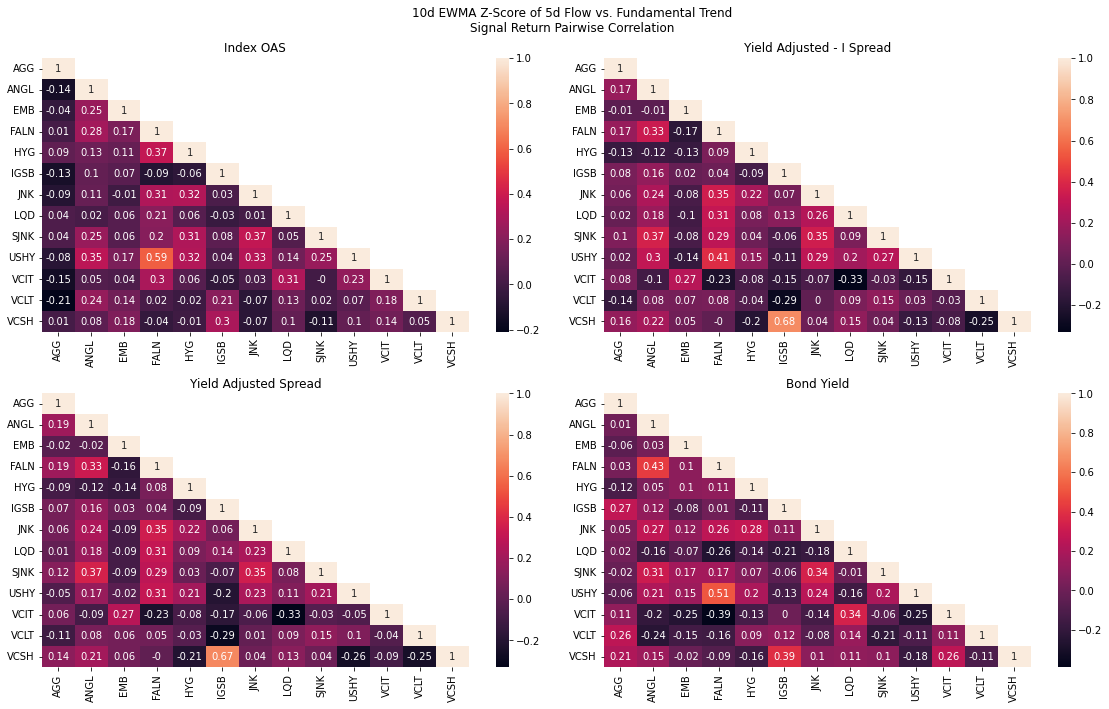

In [3]:
def plot_signal_corr(df: pd.DataFrame) -> plt.Figure: 
    
    variables = df.variable.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables) // 2, nrows = len(variables) // 2, figsize = (16,10))

    renamer = {
        "OAS"        : "Index OAS",
        "yas_ispread": "Yield Adjusted - I Spread",
        "yas_sprd"   : "Yield Adjusted Spread",
        "yas_yls"    : "Bond Yield"}
    
    for variable, ax in zip(variables, axes.flatten()):

        df_corr = (df.query(
            "variable == @variable").
            pivot(index = "date", columns = "security", values = "signal_rtn").
            corr().
            apply(lambda x: np.round(x, 2)))
        
        mask = np.tril(np.ones_like(df_corr, dtype=bool))
        df_corr = df_corr.where(mask)

        sns.heatmap(
            data  = df_corr,
            mask  = ~mask,
            ax    = ax,
            annot = True)

        ax.set_title(renamer[variable])
        ax.set_xlabel("")
        ax.set_ylabel("")

    fig.suptitle("10d EWMA Z-Score of 5d Flow vs. Fundamental Trend\nSignal Return Pairwise Correlation")
    plt.tight_layout()
    
plot_signal_corr(df)

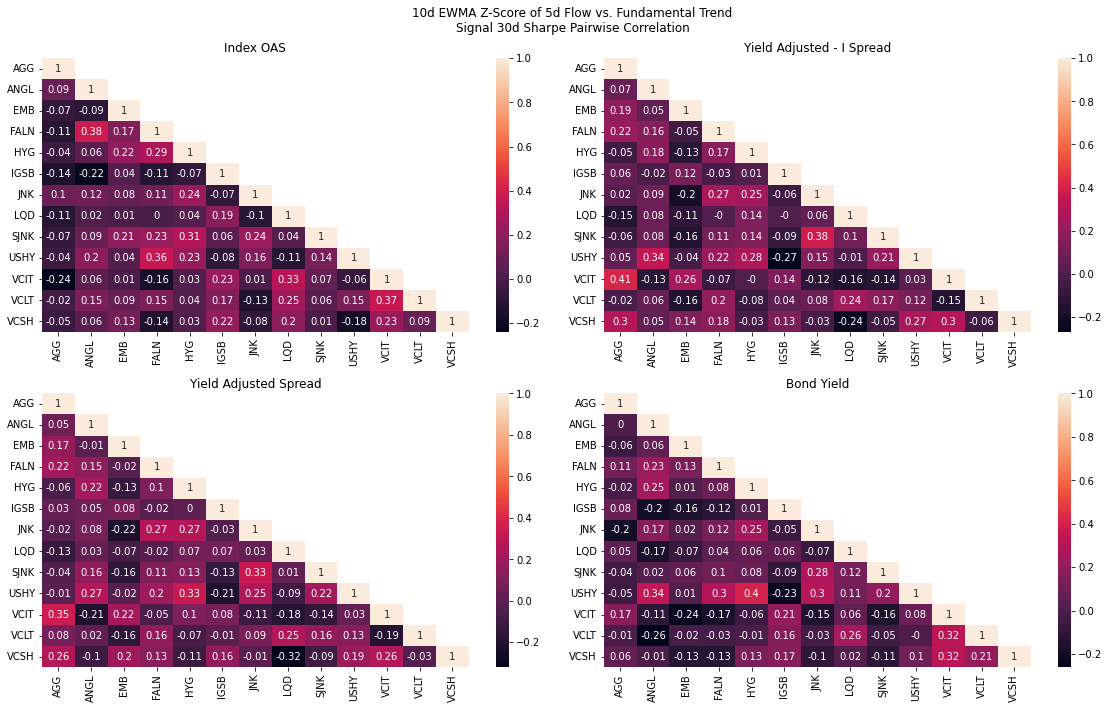

In [4]:
def plot_sharpe_corr(df: pd.DataFrame) -> plt.Figure: 
    
    variables = df.variable.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables) // 2, nrows = len(variables) // 2, figsize = (16,10))
    renamer = {
        "OAS"        : "Index OAS",
        "yas_ispread": "Yield Adjusted - I Spread",
        "yas_sprd"   : "Yield Adjusted Spread",
        "yas_yls"    : "Bond Yield"}

    for variable, ax in zip(variables, axes.flatten()):

        df_wider = (df.query(
            "variable == @variable").
            pivot(index = "date", columns = "security", values = "signal_rtn"))
        
        df_sharpe = df_wider.rolling(window = 30).mean() / df_wider.rolling(window = 30).std()
        df_corr   = df_sharpe.corr().apply(lambda x: np.round(x,2))
        
        mask = np.tril(np.ones_like(df_corr, dtype=bool))
        df_corr = df_corr.where(mask)
 
        sns.heatmap(
            data  = df_corr,
            mask  = ~mask,
            ax    = ax,
            annot = True)

        ax.set_title(renamer[variable])
        ax.set_xlabel("")
        ax.set_ylabel("")
        
    fig.suptitle("10d EWMA Z-Score of 5d Flow vs. Fundamental Trend\nSignal 30d Sharpe Pairwise Correlation")
    plt.tight_layout()
    
plot_sharpe_corr(df)